**Tugas Akhir Kecerdasan Buatan**

Datasets: FER-2013 (Facial Expressions)

| Disgust, Neutral, Fear, Angry, Sad, Surprise, Happy |

https://www.kaggle.com/datasets/msambare/fer2013

1. Zaki Marsyandi
2. Fachri Auliya Hibban Prasetyo
3. Ahmad Rasyid
4. Ahmad Hisyam Murtadho



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import zipfile
import random
import shutil

import tensorflow as tf
from tensorflow.keras import layers, models

import numpy as np
import matplotlib.pyplot as plt

from google.colab import files

import numpy as np

import matplotlib.pyplot as plt

In [ ]:
zip_path = ('/content/drive/My Drive/FER2013/fer2013.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/fer2013')

In [ ]:
scale_factor = 0.75
seed = 42
random.seed(seed)

original_train_dir = '/content/fer2013/train'
original_val_dir = '/content/fer2013/val'
original_test_dir = '/content/fer2013/test'

new_base_dir = '/content/fer2013_scaled'
new_train_dir = os.path.join(new_base_dir, 'train')
new_val_dir = os.path.join(new_base_dir, 'val')
new_test_dir = os.path.join(new_base_dir, 'test')

for dir_path in [new_train_dir, new_val_dir, new_test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path, exist_ok=True)


In [ ]:
emotion_classes = [d for d in os.listdir(original_train_dir)
                   if os.path.isdir(os.path.join(original_train_dir, d))]

print(f"Found emotion classes: {emotion_classes}")
print(f"Scaling dataset to {scale_factor*100}% of original size\n")

total_original = 0
total_scaled = 0

Found emotion classes: ['disgust', 'neutral', 'fear', 'angry', 'sad', 'surprise', 'happy']
Scaling dataset to 75.0% of original size



In [ ]:
for emotion in emotion_classes:
    print(f"Processing {emotion}...")

    for new_dir in [new_train_dir, new_val_dir, new_test_dir]:
        os.makedirs(os.path.join(new_dir, emotion), exist_ok=True)

    all_files = []

    train_emotion_dir = os.path.join(original_train_dir, emotion)
    if os.path.exists(train_emotion_dir):
        train_files = [(os.path.join(train_emotion_dir, f), 'train')
                       for f in os.listdir(train_emotion_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_files.extend(train_files)

    val_emotion_dir = os.path.join(original_val_dir, emotion)
    if os.path.exists(val_emotion_dir):
        val_files = [(os.path.join(val_emotion_dir, f), 'val')
                     for f in os.listdir(val_emotion_dir)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_files.extend(val_files)

    test_emotion_dir = os.path.join(original_test_dir, emotion)
    if os.path.exists(test_emotion_dir):
        test_files = [(os.path.join(test_emotion_dir, f), 'test')
                      for f in os.listdir(test_emotion_dir)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        all_files.extend(test_files)

    total_files = len(all_files)
    selected_count = max(1, int(total_files * scale_factor))
    selected_files = random.sample(all_files, selected_count)
    random.shuffle(selected_files)

    train_count = max(1, int(selected_count * 0.7))
    val_count = max(1, int(selected_count * 0.15))
    test_count = selected_count - train_count - val_count

    train_split = selected_files[:train_count]
    val_split = selected_files[train_count:train_count + val_count]
    test_split = selected_files[train_count + val_count:]

    def copy_files(file_list, target_dir):
        count = 0
        for src_path, _ in file_list:
            if os.path.exists(src_path):
                filename = os.path.basename(src_path)
                dst_path = os.path.join(target_dir, emotion, filename)
                shutil.copy2(src_path, dst_path)
                count += 1
        return count

    actual_train = copy_files(train_split, new_train_dir)
    actual_val = copy_files(val_split, new_val_dir)
    actual_test = copy_files(test_split, new_test_dir)

    print(f"  Original: {total_files} files")
    print(f"  Scaled: {actual_train + actual_val + actual_test} files")
    print(f"  Distribution - Train: {actual_train}, Val: {actual_val}, Test: {actual_test}")

    total_original += total_files
    total_scaled += (actual_train + actual_val + actual_test)


Processing disgust...
  Original: 547 files
  Scaled: 410 files
  Distribution - Train: 287, Val: 61, Test: 62
Processing neutral...
  Original: 6198 files
  Scaled: 4648 files
  Distribution - Train: 3253, Val: 697, Test: 698
Processing fear...
  Original: 5121 files
  Scaled: 3840 files
  Distribution - Train: 2688, Val: 576, Test: 576
Processing angry...
  Original: 4953 files
  Scaled: 3714 files
  Distribution - Train: 2599, Val: 557, Test: 558
Processing sad...
  Original: 6077 files
  Scaled: 4557 files
  Distribution - Train: 3189, Val: 683, Test: 685
Processing surprise...
  Original: 4002 files
  Scaled: 3001 files
  Distribution - Train: 2100, Val: 450, Test: 451
Processing happy...
  Original: 8989 files
  Scaled: 6741 files
  Distribution - Train: 4718, Val: 1011, Test: 1012


In [ ]:
print(f"Original total files: {total_original}")
print(f"Scaled total files: {total_scaled}")
print(f"Actual scale factor: {total_scaled/total_original:.1%}")
print(f"New dataset location: {new_base_dir}")

Original total files: 35887
Scaled total files: 26911
Actual scale factor: 75.0%
New dataset location: /content/fer2013_scaled


In [ ]:
directories = ['train', 'val', 'test']

for dir_name in directories:
    dir_path = os.path.join(new_base_dir, dir_name)
    print(f"\n{dir_name.upper()} SET:")

    if os.path.exists(dir_path):
        total_files = 0
        emotions = sorted([d for d in os.listdir(dir_path)
                           if os.path.isdir(os.path.join(dir_path, d))])

        for emotion in emotions:
            emotion_path = os.path.join(dir_path, emotion)
            file_count = len([f for f in os.listdir(emotion_path)
                              if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            total_files += file_count
            print(f"  {emotion:>10}: {file_count:>4} files")

        print(f"  {'Total':>10}: {total_files:>4} files")
    else:
        print("  Directory does not exist")



TRAIN SET:
       angry: 2599 files
     disgust:  287 files
        fear: 2688 files
       happy: 4718 files
     neutral: 3253 files
         sad: 3189 files
    surprise: 2100 files
       Total: 18834 files

VAL SET:
       angry:  557 files
     disgust:   61 files
        fear:  576 files
       happy: 1011 files
     neutral:  697 files
         sad:  683 files
    surprise:  450 files
       Total: 4035 files

TEST SET:
       angry:  558 files
     disgust:   62 files
        fear:  576 files
       happy: 1012 files
     neutral:  698 files
         sad:  685 files
    surprise:  451 files
       Total: 4042 files


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (48, 48)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/fer2013_scaled/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/fer2013_scaled/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/fer2013_scaled/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)


Found 18834 images belonging to 7 classes.
Found 4035 images belonging to 7 classes.
Found 4042 images belonging to 7 classes.


In [ ]:
model = models.Sequential([
    layers.Input(shape=(48, 48, 1)),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.15),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(256, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    layers.Dense(7, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             

 Total params: 851,175 (3.25 MB)

 Trainable params: 848,743 (3.24 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='emotion_model.keras',
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        monitor='val_loss',
        mode='min',
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
]

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2066 - loss: 2.1209
Epoch 1: val_loss improved from inf to 1.85332, saving model to best_model (2).keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.2066 - loss: 2.1204 - val_accuracy: 0.2030 - val_loss: 1.8533 - learning_rate: 0.0010
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2671 - loss: 1.7925
Epoch 2: val_loss did not improve from 1.85332
295/295 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.2671 - loss: 1.7924 - val_accuracy: 0.2456 - val_loss: 1.8646 - learning_rate: 0.0010
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3625 - loss: 1.6199
Epoch 3: val_loss did not improve from 1.85332
295/295 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.3626 - loss: 1.6198 - val_accuracy: 0.1886 - val_loss: 1.8906 - learning_rate: 0.0010
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4471 - loss: 1.4486
Epoch 4: val_loss did not improve from 1.85332
295/295 

In [ ]:
best_model = tf.keras.models.load_model('emotion_model.keras')

test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step - accuracy: 0.5878 - loss: 1.0400
Test Accuracy: 0.6573
Test Loss: 0.9190


In [ ]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

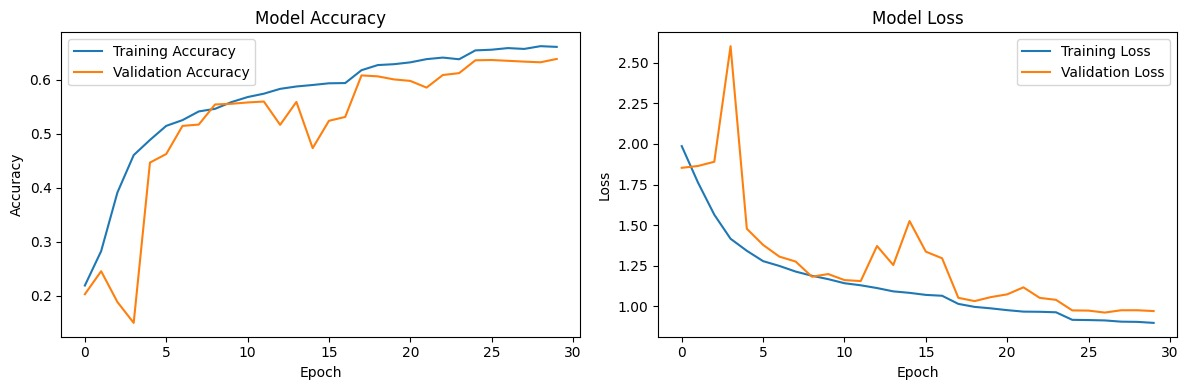

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


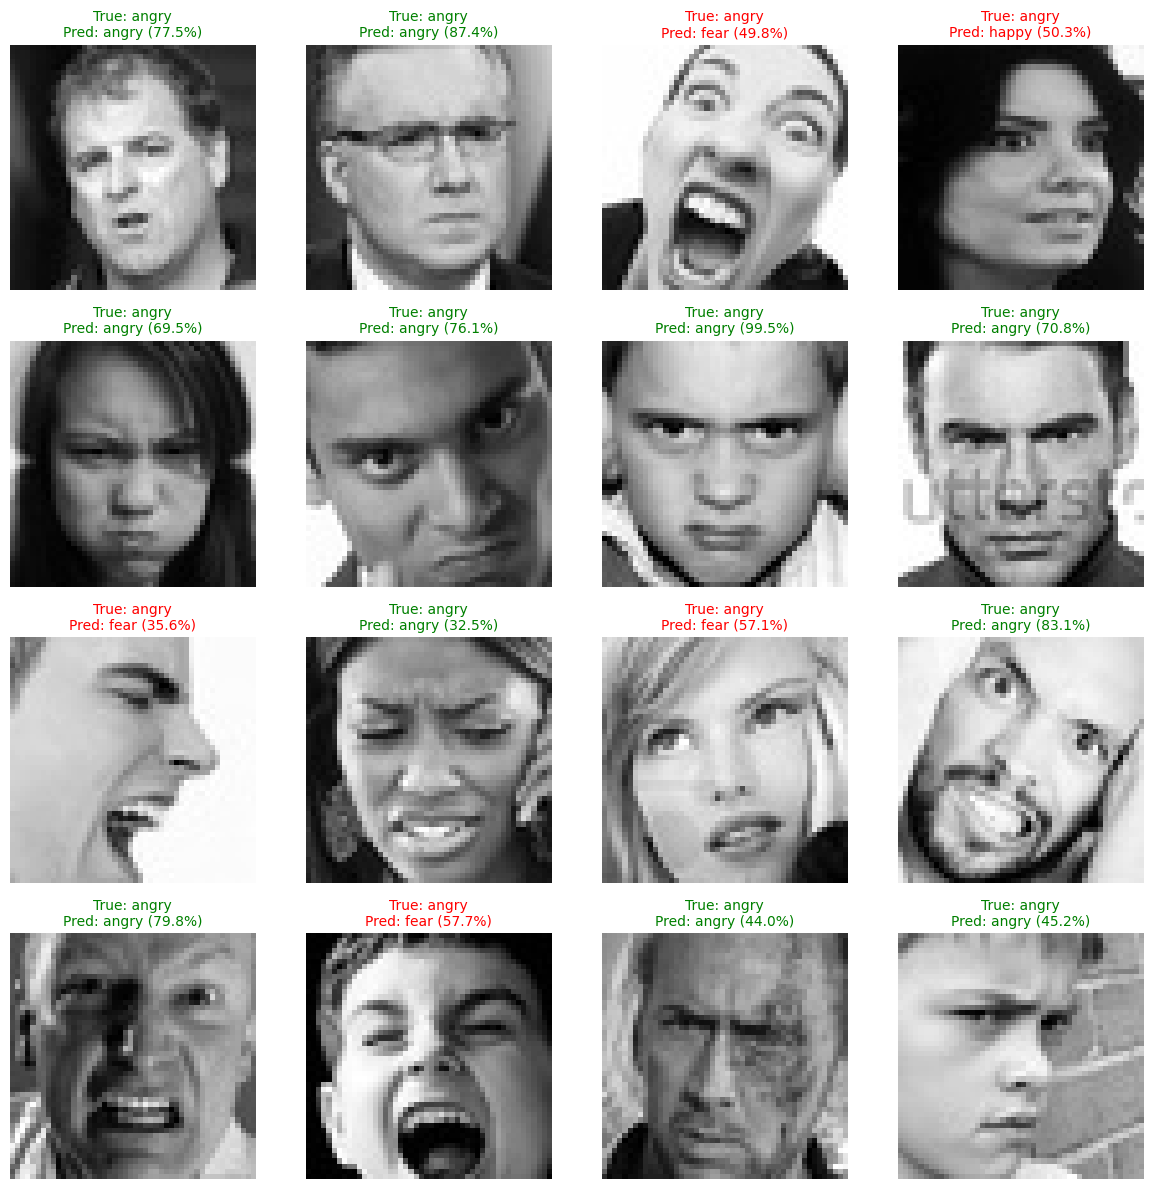

In [ ]:
def visualize_predictions(model, generator, num_images=16):
    images, true_labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(true_labels, axis=1)

    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(12, 12))
    for i in range(min(num_images, len(images))):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')

        true_emotion = class_names[true_labels[i]]
        pred_emotion = class_names[predicted_labels[i]]
        confidence = predictions[i][predicted_labels[i]] * 100

        color = 'green' if true_labels[i] == predicted_labels[i] else 'red'
        plt.title(f'True: {true_emotion}\nPred: {pred_emotion} ({confidence:.1f}%)',
                 color=color, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

test_generator.reset()
visualize_predictions(best_model, test_generator)

In [ ]:
y_pred_probs = best_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes


64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 299ms/step


              precision    recall  f1-score   support

       angry       0.59      0.54      0.56       558
     disgust       0.63      0.39      0.48        62
        fear       0.50      0.38      0.43       576
       happy       0.87      0.86      0.87      1012
     neutral       0.61      0.63      0.62       698
         sad       0.51      0.66      0.58       685
    surprise       0.76      0.77      0.76       451

    accuracy                           0.66      4042
   macro avg       0.64      0.60      0.62      4042
weighted avg       0.66      0.66      0.65      4042



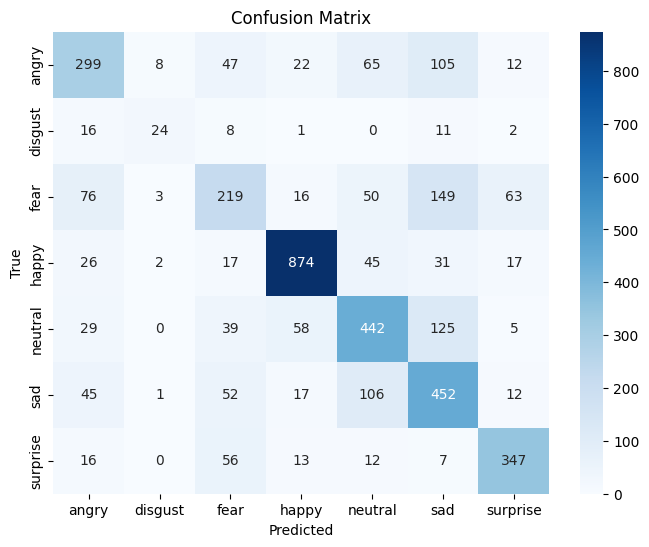

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 790.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import gradio as gr
import requests
import easyocr
from PIL import Image
import cv2
import numpy as np

API_key = "-"

reader = easyocr.Reader(['en'], gpu=False)

def get_emotion_from_image(image_path):
    image = cv2.imread(image_path)
    results = reader.readtext(image)
    extracted_text = " ".join([text[1] for text in results]).lower()

    emotion_keywords = {
        "angry": "Marah",
        "disgust": "Jijik",
        "fear": "Takut",
        "happy": "Senang",
        "sad": "Sedih",
        "surprise": "Terkejut",
        "neutral": "Netral"
    }

    for eng_emotion, indo_emotion in emotion_keywords.items():
        if eng_emotion in extracted_text:
            return indo_emotion

    return "Tidak Terdeteksi"

def get_film_recommendation(image_path):
    emotion = get_emotion_from_image(image_path)

    prompt = f"""
Kamu adalah asisten cerdas yang memberikan rekomendasi film berdasarkan emosi pengguna.

Ekspresi wajah pengguna menunjukkan emosi: **{emotion}**.

Berikan 3 rekomendasi film yang sesuai dengan emosi tersebut. Untuk setiap film, gunakan format sebagai berikut:

🎬 **Judul Film** (Skor IMDb: x.x)
Deskripsi singkat tentang film ini dan mengapa cocok untuk emosi {emotion.lower()}.

Tuliskan hasilmu dalam bahasa Indonesia. Buat hasilnya menarik dan mudah dibaca.
"""

    mistral_url = "https://api.mistral.ai/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {API_key}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "mistral-tiny",
        "messages": [
            {"role": "system", "content": "Kamu adalah asisten rekomendasi film berdasarkan suasana hati pengguna."},
            {"role": "user", "content": prompt}
        ],
        "temperature": 0.7,
        "max_tokens": 400
    }

    try:
        response = requests.post(mistral_url, headers=headers, json=payload)
        result = response.json()

        if "choices" in result:
            recommendation = result["choices"][0]["message"]["content"]
            return emotion, recommendation
        else:
            return emotion, "Gagal mendapatkan rekomendasi film."

    except requests.exceptions.RequestException as e:
        return "Tidak Terdeteksi", f"Terjadi kesalahan: {str(e)}"

with gr.Blocks() as demo:
    gr.Markdown("## 🎥 Rekomendasi Film Berdasarkan Emosi dari Gambar (OCR)")
    image_input = gr.Image(label="Unggah Foto Emosi dengan Label (OCR)", type="filepath")
    emotion_output = gr.Textbox(label="Emosi yang Terdeteksi (OCR)")
    film_output = gr.Textbox(label="Rekomendasi Film dari Mistral")

    btn = gr.Button("🎬 Dapatkan Rekomendasi Film")
    btn.click(get_film_recommendation, inputs=image_input, outputs=[emotion_output, film_output])

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9189964073cea7dda6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
